# DEX 구성하기 [2] SWAP 수행하기


---

* **DATE** : 2021.11.06
* **AUTHOR** : Kang Sang Jae
* **Reference** : 
    * [Taking undercollateralized loans for fun and for profit](https://samczsun.com/taking-undercollateralized-loans-for-fun-and-for-profit/)
    * [Arxiv Paper](https://arxiv.org/pdf/2103.12732.pdf)
    * [zuniswap with Clone Coding](https://github.com/Jeiwan/zuniswap)

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

## Price Oracle 

![](https://imgur.com/joOOygJ.png)


토큰의 가치는 시시각각 시장에서 변하고 있다. market에서 계속 거래가 발생하면서 토큰의 가치는 꾸준히 등락을 반복하고 있다. 가치가 변하기 때문에, 토큰간 교환비는 토큰 간의 가치에 따라 계속 바뀌어야 한다. 

시장 내의 가치 변화를 어떻게 반영하는 방식에는 크게 4가지 방법이 있다. 

1. Off-Chain Centralized Oracle : (ex : Compound Finance, Synthetix)
2. Off-chain Decentralized Oracle : (ex : Maker )
3. On-chain Centralized Oracle : (ex : Nuo )
4. On-chain Decentralized Oracle : (ex : uniswap )

이 중 Uniswap / sushiswap 등 현재 인기를 얻고 있는 주요 swap은 4번 방식으로, 완전히 탈중앙화된 방식으로 가격을 결정하고 있다. 가격을 결정하는 주체도 peer 간 거래에 의해 계속 갱신되는 방식이다. 

SWAP의 수요에 따라, Swap Ratio가 변해야 한다. 예를 들어, LP에서 두 토큰 $X, Y$을 스왑해주고 있다고 해보자. 트레이더들이 해당 LP에게 $X \rightarrow Y$ 방향으로 스왑 요청을 지속적으로 요청하는 상황이다. 이것은 어떤 것을 의미하는가? LP가 제시하고 있는 $R_{swap} = \frac{\delta Y}{\delta X}$ 이 시장에서 평가되는 가치 비율 ${R_{market} = \frac{P_y}{P_x}}$ 보다 높기 때문에, 차익이 발생해서 계속 요청하는 것이다. 시장의 수요가 반영되려면, $R_{swap}$은 좀 더 줄어야 한다. 

즉 기본적인 원칙은 
> **스왑 요청은 시장의 가치 변화에 대한 결과**

이다. 스왑 요청에 따라 스왑의 비율을 바꾸어 주는 역할이 바로 Automated Market Maker가 할 역할이다. 

## Constant Product Market Makers


AMM 모델 중에서 가장 간단한 모델이자, 가장 중심이 되는 모델은 Constant Product Market Makers 모델로, 핵심은 두 통화량의 곱이 일정하도록 유지하는 방향으로 swap 비율을 결정한다는 것이다. 

$$
C = S_x \cdot S_y
$$


In [3]:
class Reserves:
    # 토큰이 실제로 저장된 컨트랙트
    def __init__(self, supply_X, supply_Y):
        # X의 초기 통화 공급량 : supply_X
        # Y의 초기 통화 공급량 : supply_Y
        self.supply_X = supply_X
        self.supply_Y = supply_Y
        
    @property
    def constant(self):
        # 추가적으로 풀에 토큰이 공급되거나, 빼지 않는 경우 
        # 해당 값은 계속 유지되어야 함
        return self.supply_X * self.supply_Y

아까 일전에 설명했듯 토큰 X와 토큰 Y의 가치에 반비례하게 통화량을 준비해야 한다. 토큰 X가 20달러이고, 토큰 Y가 10달러라면, 토큰 X의 통화량($S_x$) : 토큰 y의 통화량($S_y$)은 $S_x : S_y = 1 : 2$이다. 

즉 토큰 X가 10만개를 준비했다면, 토큰 Y는 20만개를 만큼 준비해야, 유동성 풀이 올바르게 형성된다. 

In [4]:
X = 100_000
Y = 200_000

reserve = Reserves(X,Y)

print(reserve.constant)

20000000000


우리의 풀을 위와 같이 준비했다고 보자. 

## 풀에서의 스왑

그럼 이 Pool에서 Swap하기 위해서는 어떻게 해야하는가? 풀에 스왑한다는 것은 특정 토큰을 넣어서 (특정 토큰의 통화량을 높이고), 다른 토큰을 받아내는 (반대 토큰의 통화량을 낮추는) 행위입니다. 

아래와 같이 $\nabla S_x$을 스왑요청해서, $\nabla S_y$ 만큼 받아내야 한다고 봅시다. 

$$
S_x' = S_x + \nabla S_x \\
S_y' = S_y - \nabla S_y
$$

이 때, 교환 후에도 두 토큰 통화량의 곱은 일정해야 합니다. 

$$
S_x' \cdot S_y' = S_x \cdot S_y
$$

그럼 이 식을 $\nabla S_y = F(\nabla S_x)$의 구조로 정리해보면, 아래처럼 식이 정리됩니다.

$$
(S_x + \nabla S_x) (S_y - \nabla S_y) = S_x S_y \\
S_y - \nabla S_y = \frac{S_x S_y}{S_x + \nabla S_x} \\
\nabla S_y = S_y - \frac{S_x S_y}{S_x + \nabla S_x} \\
$$

위 식을 마무리해서 정리하면, 

$$
\therefore  \nabla S_y = \frac{S_y \cdot \nabla S_x}{S_x + \nabla S_x}
$$

가 나옵니다. 대칭 구조로 $\nabla S_x = F'(\nabla S_y)$ 을 구해보면

$$
\therefore  \nabla S_x = \frac{S_x \cdot \nabla S_y}{S_y + \nabla S_y}
$$

가 나옵니다.

### 스왑을 구현한 코드

In [5]:
class Reserves:
    # 토큰이 실제로 저장된 컨트랙트
    def __init__(self, supply_X, supply_Y):
        # X의 초기 통화 공급량 : supply_X
        # Y의 초기 통화 공급량 : supply_Y
        self.supply_X = supply_X
        self.supply_Y = supply_Y
        
    @property
    def constant(self):
        # 추가적으로 풀에 토큰이 공급되거나, 빼지 않는 경우 
        # 해당 값은 계속 유지되어야 함
        return self.supply_X * self.supply_Y
        
        
    def swapX2Y(self, delta_X):
        # delta_X만큼의 X 토큰을 delta_Y만큼의 Y 토큰으로 교환
        delta_Y = self.supply_Y * delta_X / (self.supply_X + delta_X)
        self.supply_X += delta_X
        self.supply_Y -= delta_Y
        return delta_Y        
        
    def swapY2X(self, delta_Y):
        # delta_Y만큼의 Y 토큰을 delta_X만큼의 X토큰으로 교환
        delta_X = self.supply_X * delta_Y / (self.supply_Y + delta_Y)
        self.supply_X -= delta_X
        self.supply_Y += delta_Y
        return delta_X                

In [6]:
X = 100_000
Y = 200_000

reserve = Reserves(X,Y)

#### Case 1) 10 만큼의 토큰 X를 넣었을 때, 얼마만큼의 토큰 Y를 받을 수 있을까? 

In [8]:

reserve.swapX2Y(10)

19.99800019998

In [9]:
reserve.supply_X

100010

In [10]:
reserve.supply_Y

199980.0019998

In [12]:
reserve.supply_X * reserve.supply_Y

20000000000.0

그렇다면 또 스왑을 요청하면 동일한 스왑비율일까? 아니다, 좀 더 줄어든다 

In [11]:
reserve.swapX2Y(10)

19.99400139970006

그래도 스왑 풀의 상수 값은 유지된다. 

In [13]:
reserve.constant

20000000000.0

그럼 교환비율은 어떻게 변화할까? 스왑이 X->Y방향으로 이루어진다고 보자. 그러면 풀의 통화 비율은 아래와 같이 바뀌어간다 

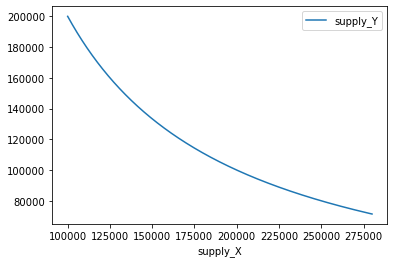

In [14]:
reserve = Reserves(X,Y)
pts = []
for i in range(180000):
    reserve.swapX2Y(1)
    pts.append((reserve.supply_X, reserve.supply_Y))
    
df = pd.DataFrame(pts, columns=["supply_X","supply_Y"])    

df.plot(x="supply_X", y="supply_Y")
plt.show()

---

## Slippage란? 

X의 통화량은 10만개, Y의 통화량은 20만개인, 다시 처음의 풀 상태로 돌려보자. 

In [15]:
X = 100_000
Y = 200_000

reserve = Reserves(X,Y)

In [16]:
reserve.supply_X

100000

In [17]:
reserve.supply_Y

200000

지금 여기의 통화량은 X의 가치가 Y의 가치보다 2배가 높다는 것을 묵시적으로 반영하고 있다. 그렇다면 이 풀에서 교환하길 희망하는 유저는 10의 X 토큰을 넣으면, 20의 Y 토큰을 받는 것이 제일 이상적인 비율이다. 그럼 다시 넣어보자

In [18]:
delta_X = 10

delta_Y = reserve.swapX2Y(delta_X)
delta_Y

19.99800019998

20을 받지 못하고, 19.998만큼밖에 못받았다. 대략 0.002 만큼의 Y를 덜 받게 되었다. 이것이 바로 **Slippage Loss**라고 불리는 손실이다. Slippage Loss의 정의는 

````
Slippage is defined as the difference between the spot price and the realized price of a trade.
````

이런 손실은 고스란히 풀을 이용하는 유저에게로 전가된다. 대신 이러한 손실은 풀의 크기가 커질수록 훨씬 줄어드는데, 아래와 같이 보자 .

In [19]:
X = 1_000_000
Y = 2_000_000

reserve_big = Reserves(X,Y)

reserve_big.swapX2Y(delta_X)

19.99980000199998

아까는 slippage가 대략 0.002만큼 발생했는데, 지금은 0.0002만큼으로 줄었다. 슬리피지의 크기는 풀 사이즈에 반비례하는데, 풀사이즈가 10배가 커지면 슬리피지는 10배가 작아진다.  즉 풀을 이용하는 유저는 물려있는 자본이 큰 풀에서 Swap을 해야 손실을 훨씬 적게 거래낼 수 있다는 것이다. 

---

## Fee, 유동성 공급자가 얻을 수 있는 이익

위에서 구성했던 풀은 토큰의 양이 **충분히 크다면** 스왑을 하려는 유저에게는 너무나 좋은 조건이다. 그럼 이런 유동성 풀에 토큰을 공급한 사람은 어떤 혜택을 누릴 수 있을까? 스왑을 이용하려는 사람에게 수수료를 떼면 되지 않을까. 매우 간단한 조건이다. FEE를 한번 붙여보자

In [20]:
class ReservesWithFee:
    fee = 0.003 # FEE는 0.3%만큼 뗀다고 해보자 
    
    
    # 토큰이 실제로 저장된 컨트랙트
    def __init__(self, supply_X, supply_Y):
        # X의 초기 통화 공급량 : supply_X
        # Y의 초기 통화 공급량 : supply_Y
        self.supply_X = supply_X
        self.supply_Y = supply_Y
        
    @property
    def constant(self):
        # 추가적으로 풀에 토큰이 공급되거나, 빼지 않는 경우 
        # 해당 값은 계속 유지되어야 함
        return self.supply_X * self.supply_Y
        
        
    def swapX2Y(self, delta_X):
        # delta_X만큼의 X 토큰을 delta_Y만큼의 Y 토큰으로 교환
        # Fee를 뗀 만큼 유저에게 돌려준다
        delta_Y = (1- self.fee) * self.supply_Y * delta_X / (self.supply_X + delta_X)
        
        self.supply_X += delta_X
        self.supply_Y -= delta_Y
        return delta_Y        
        
    def swapY2X(self, delta_Y):
        # delta_Y만큼의 Y 토큰을 delta_X만큼의 X토큰으로 교환
        # Fee를 뗀 만큼 유저에게 돌려준다
        delta_X = (1- self.fee) * self.supply_X * delta_Y / (self.supply_Y + delta_Y)
        self.supply_X -= delta_X
        self.supply_Y += delta_Y
        return delta_X                

SWAP할 때, Fee를 뗀만큼 $1-fee$만큼 유저에게 돌려주면 된다. 현재 로직에서는 0.3%로 이므로 실질적으로 유저는 0.997만큼 돌려받게 된다. 

In [21]:
X = 100_000
Y = 200_000

withFee = ReservesWithFee(X,Y)
withoutFee = Reserves(X,Y)

In [22]:
withFee.swapX2Y(10)

19.938006199380062

In [23]:
withoutFee.swapX2Y(10)

19.99800019998

In [18]:
19.938 / 19.998

0.9969996999699969

Fee만큼 유저는 떼이고 SWAP이 된다. 이 FEE는 그대로 유동성 풀 안에 고스란히 안착되게 되므로, 거래가 발생할때마다 조금씩 유동성 풀이 커지게 된다. Fee가 없었다면 withoutFee처럼 계속 constant값이 일정하지만, Fee가 존재하므로 조금씩 커지게 된다. 

In [24]:
withFee.constant

20000006000.0

In [25]:
withoutFee.constant

20000000000.0

실제로 유니스왑 내 이더리움 풀은 하루 거래량이 $1.18b$이 되고, Fee는 대략 $1.18b * 0.003 \approx 3.54m$ 가 된다, 근데 0.05% 수수료의 거래도 있어서 실제로 아래 풀의 수익은 조금 더 낮은 금액인 $2.76m$이 획득되어 있다. 

풀에 누군가가 새롭게 유동성을 공급하지 않더라도, TVL(Total Value Locked)는 조금씩 계속 커질 수 있다. 



![](https://imgur.com/BjkkzKv.png)

**잠깐 짚고 넘어가고 싶은 부분**

일 거래량이 TVL만큼 항상 발생하고, 수수료가 0.3%라고 하자. 그러면 사실상 일 이율이 0.3%와 동일해진다 (fee만큼 들어가기 때문) 그럼 이게 진짜 쭉 1년이 유지되면 어떻게 되는가? 바로 아래와 같아진다.

In [21]:
1.003**365

2.984286762108137

일년이면 3배다.

## Divergence Loss

그럼 꼭 유동성 풀에 돈 넣은 LP들이 돈을 벌고, 트레이더는 꼬박꼬박 수수료 내며 돈을 잃는 판인 것인가. 그건 아니다. LP들이 돈을 잃을 수 있는 시나리오를 보자. 

먼저 우리가 가정한 시장을 보자. X가 시중에 20달러로 거래가 되고, Y가 시중에 10달러로 거래가 되고 있다고 보자. 
$$
P_x = 20 \\
P_y = 10
$$

그리고 X토큰 10만개와, Y토큰 20만개로 유동성 풀을 형성했다고 보자. 

$$
S_x = 10^5 \\
S_y = 2 * 10^5
$$

그럼 현재의 풀 가치(TVL, total Value Locked)는 아래와 같을 것이다.

$$
TVL = P_x * S_x + P_y * S_y
$$

In [26]:
class ReservesWithFee:
    fee = 0.003 # FEE는 0.3%만큼 뗀다고 해보자 
    
    # 토큰이 실제로 저장된 컨트랙트
    def __init__(self, supply_X, supply_Y):
        # X의 초기 통화 공급량 : supply_X
        # Y의 초기 통화 공급량 : supply_Y
        self.supply_X = supply_X
        self.supply_Y = supply_Y
        
    @property
    def constant(self):
        # 추가적으로 풀에 토큰이 공급되거나, 빼지 않는 경우 
        # 해당 값은 계속 유지되어야 함
        return self.supply_X * self.supply_Y
        
    def calculate_TVL(self, price_X, price_Y):
        # 현재 price_X와 price_Y를 기준으로 풀의 총 가치 산정
        return self.supply_X * price_X + self.supply_Y * price_Y
    
        
    def swapX2Y(self, delta_X):
        # delta_X만큼의 X 토큰을 delta_Y만큼의 Y 토큰으로 교환
        # Fee를 뗀 만큼 유저에게 돌려준다
        delta_Y = (1- self.fee) * self.supply_Y * delta_X / (self.supply_X + delta_X)
        
        self.supply_X += delta_X
        self.supply_Y -= delta_Y
        return delta_Y        
        
    def swapY2X(self, delta_Y):
        # delta_Y만큼의 Y 토큰을 delta_X만큼의 X토큰으로 교환
        # Fee를 뗀 만큼 유저에게 돌려준다
        delta_X = (1- self.fee) * self.supply_X * delta_Y / (self.supply_Y + delta_Y)
        self.supply_X -= delta_X
        self.supply_Y += delta_Y
        return delta_X                

In [27]:
price_X = 20
price_Y = 10
supply_X = 100_000
supply_Y = 200_000

reserve = ReservesWithFee(supply_X, supply_Y)

실제로 이 풀의 가치는 4_000_000$, 400만 달러의 가치를 지니고 있다. 

In [24]:
reserve.calculate_TVL(price_X, price_Y)

4000000

### CASE 1) 폭등 케이스

근데 갑자기 Y토큰의 가격이 폭등해서 15달러가 되었다고 해보자. 아무런 거래가 없었더라도 아래와 같은 풀의 가치를 가질 것이다.

In [28]:
reserve.calculate_TVL(20, 15)

5000000

하지만 Y값이 폭등했는데, 해당 풀 내부의 교환비는 1개의 X를 주면 대략 2개의 Y를 주는 비율을 가지고 있다. 즉 시장 교환비는 20/15 = 1.33개인데, 아직 내 풀은 1개를 주면 2개를 주는 교환비를 가지고 있기 때문에, 차익이 발생한다. 그러면 Trader은 다른 곳에서 swap하는 것보다 여기서 swap하는 것이 훨씬 싸게 먹히기 때문에 우리 풀에서 계속 스왑할 것이다. 언제까지 스왑이 발생하냐면, 시장 교환비인 20/15보다 낮아질때까지 발생할 것이다

In [29]:
reserve = ReservesWithFee(supply_X, supply_Y)
count = 0
while True:
    count += 1
    swapped = reserve.swapX2Y(1)
    if swapped < 20/15:
        break
print(count, "번 스왑 발생")

22329 번 스왑 발생


이렇게 스왑이 발생한 후 TVL을 계산해보자

In [27]:
print("X 토큰 수 :", reserve.supply_X)
print("Y 토큰 수 :", reserve.supply_Y)
print("CONSTANT :", reserve.constant)

X 토큰 수 : 122329
Y 토큰 수 : 163592.41347667197
CONSTANT : 20012096348.187805


In [28]:
print("전체 TVL : ", reserve.calculate_TVL(20,15))

전체 TVL :  4900466.202150079


아까 스왑이 발생하지 않았더라면, 500만 달러의 가치를 가지고 있을 텐데, 스왑이 지속적으로 발생하면서 490만 달러의 가치를 가지게 되었다. 즉 유동성 풀에 넣었기 때문에 잠재적으로 10만 달러의 손실이 발생했다. 이는 FEE를 받지만, 그것으로도 충당되지 않은 수준의 손실을 입게 되었다.

### CASE 2) 폭락 케이스

거꾸로 Y토큰의 가격이 폭락해서 5달러가 되었다고 해보자. 아무런 거래가 없었더라도 아래와 같은 풀의 가치를 가질 것이다.

In [30]:
supply_X = 100_000
supply_Y = 200_000

reserve = ReservesWithFee(supply_X, supply_Y)

reserve.calculate_TVL(20, 5)

3000000

원래 400만이어야 하는데, 폭락해서 300만 달러가 되었다. 현재 시장에서는 $P_x : P_y = 1 : 4$의 가치를 가지고 있어서, 하나의 Y로 0.25 개의 X를 교환할 수 있는데, 풀에서의 교환비는 $P_x : P_y = 1 : 2$의 가치를 가지고 있기 때문에, 하나의 Y로 0.5개의 X를 교환해주게 된다. 트레이더들은 여기서 비용을 지불할 것이고, 시장 교환비인 0.25일때까지 계속 발생할 것이다. 

In [31]:
reserve = ReservesWithFee(supply_X, supply_Y)
count = 0
while True:
    count += 1
    swapped = reserve.swapY2X(1)
    if swapped < 1/4:
        break
print(count, "번 스왑 발생")

82566 번 스왑 발생


In [32]:
reserve.calculate_TVL(20, 5)

2829896.914192222

스왑되지 않았으면 손실이 없었을텐데 스왑이 되었기 때문에, 손실이 좀더 극대화되었다. 

관점을 바꾸어서 트레이더의 관점에서 보자. 트레이더가 처음에 10만개의 Y토큰이 있었다고 해보자. 

In [32]:
trader_supply_Y = 100000

트레이더의 입장에서는 폭락하자 남은 돈은 아래와 같다. 

In [33]:
trader_supply_Y * 5

500000

하지만 위 시장에서 스왑을 시도해본다고 생각해보자.

In [33]:
reserve = ReservesWithFee(supply_X, supply_Y)
total_X = 0
swap_Y = 0
while True:
    swap_Y += 1
    swapped = reserve.swapY2X(1)
    total_X += swapped
    if swapped < 1/4:
        break
print(f"Y토큰 {swap_Y}개을 스왑해서 X토큰 {total_X:.2f}개 획득")

Y토큰 82566개을 스왑해서 X토큰 29146.65개 획득


이러면 트레이더는 자신이 가진 10만개의 Y토큰 중 82566개를 스왑해버리고, X토큰 29146.65개를 획득하게 된다.

In [35]:
trader_total = (100000 - swap_Y) * 5 + total_X * 20
trader_total

670103.0858077708

트레이더는 사실상 670103 - 500000 = 170103만큼 벌었다. 이 관계를 잘 보면, 유동성 풀 공급자가 추가적으로 더 잃은 만큼을 트레이더는 더 벌어낸 것이다. 기본적인 시장의 구조가 위와 같기 때문에, 트레이더와 유동성 풀 공급자의 **ZERO-SUM GAME**을 하는 구조라고 볼 수 있다. 

유동성 풀 공급자가 잃는다면, 트레이더는 벌 것이고, 유동성 풀 공급자가 얻는다면, 그만큼 트레이더는 잃을 것이다. 이것이 DEX의 대원칙이라고 할 수 있다. 

----

*Copyright 2021.11 M3O1(Kang Sang Jae) all rights reserved.*